# Data Preparation
Pipeline: Data Preparation -> Feature Encoding -> Training Phase -> Prediction Phase -> Evaluation

## Setup

In [ ]:
import nltk
from nltk.corpus import brown
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Data Discovery

Load Dataset

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')
tagged_sents = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
print(tagged_sents[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


Flatten all sentences into a list of (word, tag) tuples

In [ ]:
data = [(word, tag) for sent in tagged_sents for word, tag in sent]

Convert data array into pandas dataframe

In [ ]:
df = pd.DataFrame(data, columns=['word', 'tag'])

In [ ]:
df.head()

,word,tag
0,The,DET
1,Fulton,NOUN
2,County,NOUN
3,Grand,ADJ
4,Jury,NOUN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161192 entries, 0 to 1161191
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   word    1161192 non-null  object
 1   tag     1161192 non-null  object
dtypes: object(2)
memory usage: 17.7+ MB


In [ ]:
df['tag'].unique()

array(['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT',
       'PRON', 'NUM', 'X'], dtype=object)

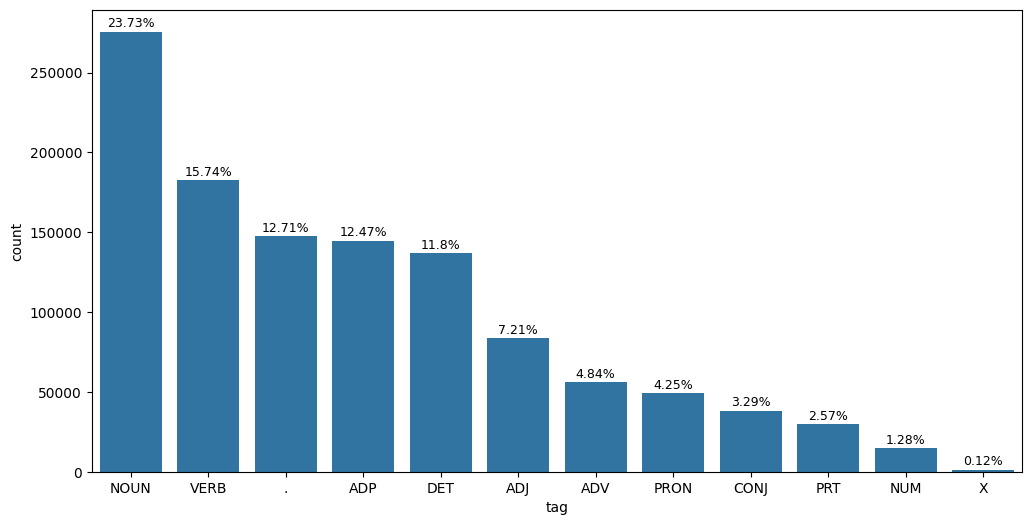

In [ ]:
tag_counts = df['tag'].value_counts()
tag_percentages = (tag_counts / len(df) * 100).round(2)

plt.figure(figsize=(12, 6))
ax = sns.countplot(df, x='tag', order=df['tag'].value_counts().index)

for i, (count, pct) in enumerate(zip(tag_counts.values, tag_percentages.values)):
    ax.text(i, count + 1000, f'{pct}%', ha='center', va='bottom', fontsize=9)

# Data Preprocessing
## Feature Engineering

For each sentence in the data, add **context** to every single word:

- `sentence_id`: indicates which sentence a specified word is part of

- `word`: the current word

- `prev_word`: the previous word; 'BOS' refers to 'before of sentence'

- `next_word`: the next word; 'EOS' refers to 'end of sentence'

In [ ]:
data = []
for sent_id, sent in enumerate(tagged_sents):
    for position, (word, tag) in enumerate(sent):
        # Get previous and next words for context
        prev_word = sent[position-1][0] if position > 0 else '<BOS>'
        next_word = sent[position+1][0] if position < len(sent)-1 else '<EOS>'

        data.append({
            'sentence_id': sent_id,
            'word': word.lower(),
            'prev_word': prev_word.lower(),
            'next_word': next_word.lower(),
            'tag': tag
        })

In [ ]:
df = pd.DataFrame(data)
# First sentence
df[df['sentence_id'] == 0]

,sentence_id,word,prev_word,next_word,tag
0,0,the,<bos>,fulton,DET
1,0,fulton,the,county,NOUN
2,0,county,fulton,grand,NOUN
3,0,grand,county,jury,ADJ
4,0,jury,grand,said,NOUN
5,0,said,jury,friday,VERB
6,0,friday,said,an,NOUN
7,0,an,friday,investigation,DET
8,0,investigation,an,of,NOUN
9,0,of,investigation,atlanta's,ADP


## Train Test Split (80% 20%)

In [ ]:
from sklearn.model_selection import train_test_split

Split by sentence to avoid leakage

In [ ]:
unique_sentences = df['sentence_id'].unique()
train_sents, test_sents = train_test_split(unique_sentences, test_size=0.2, random_state=42)

train_df = df[df['sentence_id'].isin(train_sents)].reset_index(drop=True)
test_df = df[df['sentence_id'].isin(test_sents)].reset_index(drop=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(929265, 5)
(231927, 5)


## Feature Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

Separate encoders for each feature

In [ ]:
word_encoder = LabelEncoder()
prev_encoder = LabelEncoder()
next_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

Fit training data into encoder

In [ ]:
word_encoder.fit(train_df['word'].tolist() + ['<UNK>'])
prev_encoder.fit(train_df['prev_word'].tolist() + ['<UNK>'])
next_encoder.fit(train_df['next_word'].tolist() + ['<UNK>'])
tag_encoder.fit(train_df['tag'])

LabelEncoder()

In [ ]:
print(word_encoder.classes_)
print(prev_encoder.classes_)
print(next_encoder.classes_)
print(tag_encoder.classes_)

['!' '$.027' '$.03' ... 'zurich' 'zworykin' '{0,t}']
['!' '$.027' '$.03' ... 'zurich' 'zworykin' '{0,t}']
['!' '$.027' '$.03' ... 'zurich' 'zworykin' '{0,t}']
['.' 'ADJ' 'ADP' 'ADV' 'CONJ' 'DET' 'NOUN' 'NUM' 'PRON' 'PRT' 'VERB' 'X']


Helper function to transform encoder into array

In [ ]:
def transform_helper(encoder, data):

    word_to_id = {word: idx for idx, word in enumerate(encoder.classes_)}
    unk_id = word_to_id['<UNK>']

    result = np.array([word_to_id.get(item, unk_id) for item in data])

    return result

Transform features and label; stack features for model fitting

In [ ]:
word_train = transform_helper(word_encoder, train_df['word'])
prev_train = transform_helper(prev_encoder, train_df['prev_word'])
next_train = transform_helper(next_encoder, train_df['next_word'])

X_train = np.column_stack([word_train, prev_train, next_train])
y_train = tag_encoder.transform(train_df['tag'])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(929265, 3)
(929265,)


Label Encode Test Data

In [ ]:
word_test = transform_helper(word_encoder, test_df['word'])
prev_test = transform_helper(prev_encoder, test_df['prev_word'])
next_test = transform_helper(next_encoder, test_df['next_word'])

X_test = np.column_stack([word_test, prev_test, next_test])
y_test = tag_encoder.transform(test_df['tag'])

In [ ]:
print(X_test.shape)
print(y_test.shape)

(231927, 3)
(231927,)


# Training Phase

In [ ]:
from sklearn.naive_bayes import CategoricalNB
import time

In [ ]:
nb = CategoricalNB()
training_start = time.perf_counter()
nb.fit(X_train, y_train)
training_end = time.perf_counter()
training_time = training_end - training_start
print(f'Training time: {training_time:.4f} seconds')

Training time: 0.7890 seconds


# Prediction Phase

In [ ]:
inference_start = time.perf_counter()
y_pred = nb.predict(X_test)
inference_end = time.perf_counter()
inference_time = inference_end - inference_start
print(f'Inference time: {inference_time:.4f} seconds')

Inference time: 0.1373 seconds


Classification Report

In [ ]:
from sklearn.metrics import classification_report

labels = tag_encoder.classes_
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=labels))

              precision    recall  f1-score   support

           .       0.98      1.00      0.99     29520
         ADJ       0.89      0.89      0.89     16772
         ADP       0.94      0.98      0.96     28768
         ADV       0.92      0.88      0.90     11271
        CONJ       0.97      0.99      0.98      7529
         DET       0.94      0.99      0.96     27474
        NOUN       0.95      0.94      0.94     54822
         NUM       0.97      0.67      0.79      2911
        PRON       0.94      0.97      0.95      9934
         PRT       0.92      0.84      0.88      5853
        VERB       0.97      0.94      0.95     36744
           X       0.81      0.07      0.12       329

    accuracy                           0.95    231927
   macro avg       0.93      0.85      0.86    231927
weighted avg       0.95      0.95      0.95    231927



Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

<Axes: >

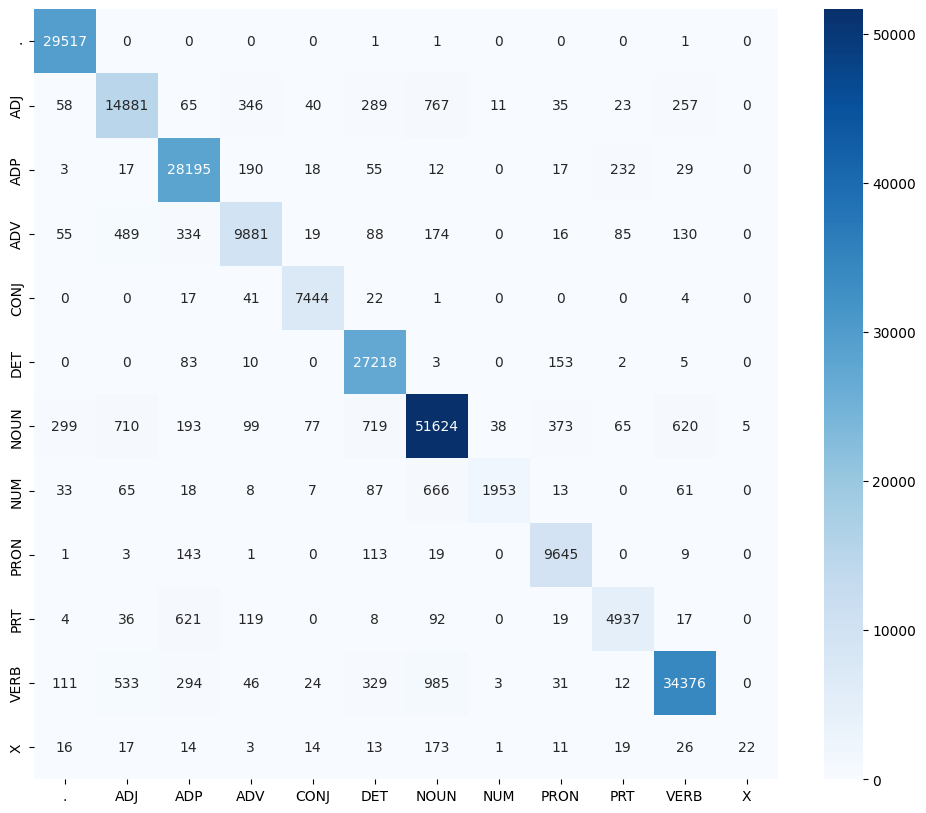

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)